________________
# Imports
________________

In [1]:
import os
import os.path as op
import glob
import nibabel as nb
import numpy as np
import pandas as pd
from pandas import json_normalize
from tqdm import tqdm
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import urllib.request
import zipfile
from pycocotools.coco import COCO
from IPython import embed
import argparse
import os
import numpy as np
import pandas as pd
import scipy.io

________________
# NSDAcess Class 
________________


In [2]:
class NSDAccess(object):
    """
    Little class that provides easy access to the NSD data, see [http://naturalscenesdataset.org](their website)
    """

    def __init__(self, nsd_folder, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.nsd_folder = nsd_folder
        self.nsddata_folder = op.join(self.nsd_folder, 'nsddata')
        self.ppdata_folder = op.join(self.nsd_folder, 'nsddata', 'ppdata')
        self.nsddata_betas_folder = op.join(
            self.nsd_folder, 'nsddata_betas', 'ppdata')

        self.behavior_file = op.join(
            self.ppdata_folder, '{subject}', 'behav', 'responses.tsv')
        self.stimuli_file = op.join(
            self.nsd_folder, 'nsddata_stimuli', 'stimuli', 'nsd', 'nsd_stimuli.hdf5')
        self.stimuli_description_file = op.join(
            self.nsd_folder, 'nsddata', 'experiments', 'nsd', 'nsd_stim_info_merged.csv')

        self.coco_annotation_file = op.join(
            self.nsd_folder, 'nsddata_stimuli', 'stimuli', 'nsd', 'annotations', '{}_{}.json')

    def download_coco_annotation_file(self, url='http://images.cocodataset.org/annotations/annotations_trainval2017.zip'):
        """download_coco_annotation_file downloads and extracts the relevant annotations files

        Parameters
        ----------
        url : str, optional
            url for zip file containing annotations, by default 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
        """
        print('downloading annotations from {}'.format(url))
        filehandle, _ = urllib.request.urlretrieve(url)
        zip_file_object = zipfile.ZipFile(filehandle, 'r')
        zip_file_object.extractall(path=op.split(
            op.split(self.coco_annotation_file)[0])[0])

    def affine_header(self, subject, data_format='func1pt8mm'):
        """affine_header affine and header, for construction of Nifti image

        Parameters
        ----------
        subject : str
            subject identifier, such as 'subj01'
        data_format : str, optional
            what type of data format, from ['func1pt8mm', 'func1mm'], by default 'func1pt8mm'

        Returns
        -------
        tuple
            affine and header, for construction of Nifti image
        """
        full_path = op.join(self.ppdata_folder,
                            '{subject}', '{data_format}', 'brainmask.nii.gz')
        full_path = full_path.format(subject=subject,
                                     data_format=data_format)
        nii = nb.load(full_path)

        return nii.affine, nii.header

    def read_vol_ppdata(self, subject, filename='brainmask', data_format='func1pt8mm'):
        """load_brainmask, returns boolean brainmask for volumetric data formats

        Parameters
        ----------
        subject : str
            subject identifier, such as 'subj01'
        data_format : str, optional
            what type of data format, from ['func1pt8mm', 'func1mm'], by default 'func1pt8mm'

        Returns
        -------
        numpy.ndarray, 4D (bool)
            brain mask array
        """
        full_path = op.join(self.ppdata_folder,
                            '{subject}', '{data_format}', '{filename}.nii.gz')
        full_path = full_path.format(subject=subject,
                                     data_format=data_format,
                                     filename=filename)
        return nb.load(full_path).get_data()

    def read_betas(self, subject, session_index, trial_index=[], data_type='betas_fithrf_GLMdenoise_RR', data_format='fsaverage', mask=None):
        """read_betas read betas from MRI files

        Parameters
        ----------
        subject : str
            subject identifier, such as 'subj01'
        session_index : int
            which session, counting from 1
        trial_index : list, optional
            which trials from this session's file to return, by default [], which returns all trials
        data_type : str, optional
            which type of beta values to return from ['betas_assumehrf', 'betas_fithrf', 'betas_fithrf_GLMdenoise_RR', 'restingbetas_fithrf'], by default 'betas_fithrf_GLMdenoise_RR'
        data_format : str, optional
            what type of data format, from ['fsaverage', 'func1pt8mm', 'func1mm'], by default 'fsaverage'
        mask : numpy.ndarray, if defined, selects 'mat' data_format, needs volumetric data_format
            binary/boolean mask into mat file beta data format.

        Returns
        -------
        numpy.ndarray, 2D (fsaverage) or 4D (other data formats)
            the requested per-trial beta values
        """
        data_folder = op.join(self.nsddata_betas_folder,
                              subject, data_format, data_type)
        print(f"This is the data folder : {data_folder}")
        
        si_str = str(session_index).zfill(2)

        if type(mask) == np.ndarray:  # will use the mat file iff exists, otherwise boom!
            ipf = op.join(data_folder, f'betas_session{si_str}.mat')
            print(f"This is ipf file : {ipf}")
            assert op.isfile(ipf), \
                'Error: ' + ipf + ' not available for masking. You may need to download these separately.'
            # will do indexing of both space and time in one go for this option,
            # so will return results immediately from this
            h5 = h5py.File(ipf, 'r')
            betas = h5.get('betas')
            # embed()
            if len(trial_index) == 0:
                trial_index = slice(0, betas.shape[0])
            # this isn't finished yet - binary masks cannot be used for indexing like this
            return betas[trial_index, np.nonzero(mask)]

        if data_format == 'fsaverage':
            session_betas = []
            for hemi in ['lh', 'rh']:
                hdata = nb.load(op.join(
                    data_folder, f'{hemi}.betas_session{si_str}.mgh')).get_data()
                session_betas.append(hdata)
            out_data = np.squeeze(np.vstack(session_betas))
            if len(trial_index) == 0:
                trial_index = slice(0, out_data.shape[-1])

            return out_data[..., trial_index]

        else:
            # if no mask was specified, we'll use the nifti image
            ipf = op.join(data_folder, f'betas_session{si_str}.hdf5')
            print("Mask not specified ")
            print(f"we used nifti image : image_path_file is \n {ipf}")
            h5 = h5py.File(ipf, 'r')
            betas = h5.get('betas')
            # out_data = nb.load(
            #     op.join(data_folder, f'betas_session{si_str}.nii.gz')).get_data()

            if len(trial_index) == 0:
                # trial_index = slice(0, out_data.shape[-1])
                trial_index = slice(0, betas.shape[0])

            return betas[trial_index,:]


    def read_mapper_results(self, subject, mapper='prf', data_type='angle', data_format='fsaverage'):
        """read_mapper_results [summary]

        Parameters
        ----------
        subject : str
            subject identifier, such as 'subj01'
        mapper : str, optional
            first part of the mapper filename, by default 'prf'
        data_type : str, optional
            second part of the mapper filename, by default 'angle'
        data_format : str, optional
            what type of data format, from ['fsaverage', 'func1pt8mm', 'func1mm'], by default 'fsaverage'

        Returns
        -------
        numpy.ndarray, 2D (fsaverage) or 4D (other data formats)
            the requested mapper values
        """
        if data_format == 'fsaverage':
            # unclear for now where the fsaverage mapper results would be
            # as they are still in fsnative format now.
            raise NotImplementedError(
                'no mapper results in fsaverage present for now')
        else:  # is 'func1pt8mm' or 'func1mm'
            return self.read_vol_ppdata(subject=subject, filename=f'{mapper}_{data_type}', data_format=data_format)

    def read_atlas_results(self, subject, atlas='HCP_MMP1', data_format='fsaverage'):
        """read_atlas_results [summary]

        Parameters
        ----------
        subject : str
            subject identifier, such as 'subj01'
            for surface-based data formats, subject should be the same as data_format.
            for example, for fsaverage, both subject and data_format should be 'fsaverage'
            this requires a little more typing but makes data format explicit
        atlas : str, optional
            which atlas to read,
            for volume formats, any of ['HCP_MMP1', 'Kastner2015', 'nsdgeneral', 'visualsulc'] for volume,
            for fsaverage
            can be prefixed by 'lh.' or 'rh.' for hemisphere-specific atlases in volume
            for surface: takes both hemispheres by default, instead when prefixed by '.rh' or '.lh'.
            By default 'HCP_MMP1'.
        data_format : str, optional
            what type of data format, from ['fsaverage', 'func1pt8mm', 'func1mm', 'MNI'], by default 'fsaverage'

        Returns
        -------
        numpy.ndarray, 1D/2D (surface) or 3D/4D (volume data formats)
            the requested atlas values
        dict,
            dictionary containing the mapping between ROI names and atlas values
        """

        # first, get the mapping.
        atlas_name = atlas
        if atlas[:3] in ('rh.', 'lh.'):
            atlas_name = atlas[3:]

        mapp_df = pd.read_csv(os.path.join(self.nsddata_folder, 'freesurfer', 'fsaverage',
                                           'label', f'{atlas_name}.mgz.ctab'), delimiter=' ', header=None, index_col=0)
        atlas_mapping = mapp_df.to_dict()[1]
        # dict((y,x) for x,y in atlas_mapping.iteritems())
        atlas_mapping = {y: x for x, y in atlas_mapping.items()}

        if data_format not in ('func1pt8mm', 'func1mm', 'MNI'):
            # if surface based results by exclusion
            if atlas[:3] in ('rh.', 'lh.'):  # check if hemisphere-specific atlas requested
                ipf = op.join(self.nsddata_folder, 'freesurfer',
                              subject, 'label', f'{atlas}.mgz')
                return np.squeeze(nb.load(ipf).get_data()), atlas_mapping
            else:  # more than one hemisphere requested
                session_betas = []
                for hemi in ['lh', 'rh']:
                    hdata = nb.load(op.join(
                        self.nsddata_folder, 'freesurfer', subject, 'label', f'{hemi}.{atlas}.mgz')).get_data()
                    session_betas.append(hdata)
                out_data = np.squeeze(np.vstack(session_betas))
                return out_data, atlas_mapping
        else:  # is 'func1pt8mm', 'MNI', or 'func1mm'
            ipf = op.join(self.ppdata_folder, subject,
                          data_format, 'roi', f'{atlas}.nii.gz')
            return nb.load(ipf).get_fdata(), atlas_mapping

    def list_atlases(self, subject, data_format='fsaverage', abs_paths=False):
        """list_atlases [summary]

        Parameters
        ----------
        subject : str
            subject identifier, such as 'subj01'
            for surface-based data formats, subject should be the same as data_format.
            for example, for fsaverage, both subject and data_format should be 'fsaverage'
            this requires a little more typing but makes data format explicit
        data_format : str, optional
            what type of data format, from ['fsaverage', 'func1pt8mm', 'func1mm', 'MNI'], by default 'fsaverage'

        Returns
        -------
        list
            collection of absolute path names to
        """
        if data_format in ('func1pt8mm', 'func1mm', 'MNI'):
            atlas_files = glob.glob(
                op.join(self.ppdata_folder, subject, data_format, 'roi', '*.nii.gz'))
        else:
            atlas_files = glob.glob(
                op.join(self.nsddata_folder, 'freesurfer', subject, 'label', '*.mgz'))

        # print this
        import pprint
        pp = pprint.PrettyPrinter(indent=4)
        print('Atlases found in {}:'.format(op.split(atlas_files[0])[0]))
        pp.pprint([op.split(f)[1] for f in atlas_files])
        if abs_paths:
            return atlas_files
        else:  # this is the format which you can input into other functions, so this is the default
            return np.unique([op.split(f)[1].replace('lh.', '').replace('rh.', '').replace('.mgz', '').replace('.nii.gz', '') for f in atlas_files])

    def read_behavior(self, subject, session_index, trial_index=[]):
        """read_behavior [summary]

        Parameters
        ----------
        subject : str
            subject identifier, such as 'subj01'
        session_index : int
            which session, counting from 0
        trial_index : list, optional
            which trials from this session's behavior to return, by default [], which returns all trials

        Returns
        -------
        pandas DataFrame
            DataFrame containing the behavioral information for the requested trials
        """

        behavior = pd.read_csv(self.behavior_file.format(
            subject=subject), delimiter='\t')
        print("The behavior is read from the file :") 
        print(self.behavior_file.format(subject=subject))

        # the behavior is encoded per run.
        # I'm now setting this function up so that it aligns with the timepoints in the fmri files,
        # i.e. using indexing per session, and not using the 'run' information.
        session_behavior = behavior[behavior['SESSION'] == session_index]

        if len(trial_index) == 0:
            trial_index = slice(0, len(session_behavior))

        return session_behavior.iloc[trial_index]

    def read_images(self, image_index, show=False):
        """read_images reads a list of images, and returns their data

        Parameters
        ----------
        image_index : list of integers
            which images indexed in the 73k format to return
        show : bool, optional
            whether to also show the images, by default False

        Returns
        -------
        numpy.ndarray, 3D
            RGB image data
        """

        if not hasattr(self, 'stim_descriptions'):
            self.stim_descriptions = pd.read_csv(
                self.stimuli_description_file, index_col=0)

        sf = h5py.File(self.stimuli_file, 'r')
        sdataset = sf.get('imgBrick')
        if show:
            f, ss = plt.subplots(1, len(image_index),
                                 figsize=(6*len(image_index), 6))
            if len(image_index) == 1:
                ss = [ss]
            for s, d in zip(ss, sdataset[image_index]):
                s.axis('off')
                s.imshow(d)
        return sdataset[image_index]

    def read_image_coco_info(self, image_index, info_type='captions', show_annot=False, show_img=False):
        """image_coco_info returns the coco annotations of a single image or a list of images

        Parameters
        ----------
        image_index : list of integers
            which images indexed in the 73k format to return the captions for
        info_type : str, optional
            what type of annotation to return, from ['captions', 'person_keypoints', 'instances'], by default 'captions'
        show_annot : bool, optional
            whether to show the annotation, by default False
        show_img : bool, optional
            whether to show the image (from the nsd formatted data), by default False

        Returns
        -------
        coco Annotation
            coco annotation, to be used in subsequent analysis steps

                Example
                -------
                single image:
                        ci = read_image_coco_info(
                            [569], info_type='captions', show_annot=False, show_img=False)
                list of images:
                        ci = read_image_coco_info(
                            [569, 2569], info_type='captions')

        """
        if not hasattr(self, 'stim_descriptions'):
            self.stim_descriptions = pd.read_csv(
                self.stimuli_description_file, index_col=0)
        if len(image_index) == 1:
            subj_info = self.stim_descriptions.iloc[image_index[0]]

            # checking whether annotation file for this trial exists.
            # This may not be the right place to call the download, and
            # re-opening the annotations for all images separately may be slowing things down
            # however images used in the experiment seem to have come from different sets.
            annot_file = self.coco_annotation_file.format(
                info_type, subj_info['cocoSplit'])
#             print('getting annotations from ' + annot_file)
            if not os.path.isfile(annot_file):
#                 print('annotations file not found')
                self.download_coco_annotation_file()

            coco = COCO(annot_file)
            coco_annot_IDs = coco.getAnnIds([subj_info['cocoId']])
            coco_annot = coco.loadAnns(coco_annot_IDs)

            if show_img:
                self.read_images(image_index, show=True)

            if show_annot:
                # still need to convert the annotations (especially person_keypoints and instances) to the right reference frame,
                # because the images were cropped. See image information per image to do this.
                coco.showAnns(coco_annot)

        elif len(image_index) > 1:

            # we output a list of annots
            coco_annot = []

            # load train_2017
            annot_file = self.coco_annotation_file.format(
                info_type, 'train2017')
            coco_train = COCO(annot_file)

            # also load the val 2017
            annot_file = self.coco_annotation_file.format(
                info_type, 'val2017')
            coco_val = COCO(annot_file)

            for image in image_index:
                subj_info = self.stim_descriptions.iloc[image]
                if subj_info['cocoSplit'] == 'train2017':
                    coco_annot_IDs = coco_train.getAnnIds(
                        [subj_info['cocoId']])
                    coco_ann = coco_train.loadAnns(coco_annot_IDs)
                    coco_annot.append(coco_ann)

                elif subj_info['cocoSplit'] == 'val2017':
                    coco_annot_IDs = coco_val.getAnnIds(
                        [subj_info['cocoId']])
                    coco_ann = coco_val.loadAnns(coco_annot_IDs)
                    coco_annot.append(coco_ann)

        return coco_annot

    def read_image_coco_category(self, image_index):
        """image_coco_category returns the coco category of a single image or a list of images
        
        Args:
            image_index ([list of integers]):  which images indexed in the 73k format to return
                                               the category for

        Returns
        -------
        coco category
        coco category, to be used in subsequent analysis steps

            Example
            -------
            single image:
                    ci = read_image_coco_category(
                        [569])
            list of images:
                    ci = read_image_coco_category(
                        [569, 2569])
        """

        if not hasattr(self, 'stim_descriptions'):
            self.stim_descriptions = pd.read_csv(
                self.stimuli_description_file, index_col=0)

        if len(image_index) == 1:
            subj_info = self.stim_descriptions.iloc[image_index[0]]
            coco_id = subj_info['cocoId']

            # checking whether annotation file for this trial exists.
            # This may not be the right place to call the download, and
            # re-opening the annotations for all images separately may be slowing things down
            # however images used in the experiment seem to have come from different sets.
            annot_file = self.coco_annotation_file.format(
                'instances', subj_info['cocoSplit'])
            print('getting annotations from ' + annot_file)
            if not os.path.isfile(annot_file):
                print('annotations file not found')
                self.download_coco_annotation_file()

            coco = COCO(annot_file)

            cat_ids = coco.getCatIds()
            categories = json_normalize(coco.loadCats(cat_ids))
            
            coco_cats = []
            for cat_id in cat_ids:
                this_img_list = coco.getImgIds(catIds=[cat_id])
                if coco_id in this_img_list:
                    this_cat = np.asarray(categories[categories['id']==cat_id]['name'])[0]
                    coco_cats.append(this_cat)

        elif len(image_index) > 1:

            # we output a list of annots
            coco_cats = []

            # load train_2017
            annot_file = self.coco_annotation_file.format(
                'instances', 'train2017')
            coco_train = COCO(annot_file)
            cat_ids_train = coco_train.getCatIds()
            categories_train = json_normalize(coco_train.loadCats(cat_ids_train))

            # also load the val 2017
            annot_file = self.coco_annotation_file.format(
                'instances', 'val2017')
            coco_val = COCO(annot_file)
            cat_ids_val = coco_val.getCatIds()
            categories_val = json_normalize(coco_val.loadCats(cat_ids_val))

            for image in tqdm(image_index, bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}'):
                subj_info = self.stim_descriptions.iloc[image]
                coco_id = subj_info['cocoId']
                image_cat = []
                if subj_info['cocoSplit'] == 'train2017':
                    for cat_id in cat_ids_train:
                        this_img_list = coco_train.getImgIds(catIds=[cat_id])
                        if coco_id in this_img_list:
                            this_cat = np.asarray(categories_train[categories_train['id']==cat_id]['name'])[0]
                            image_cat.append(this_cat)
                
                elif subj_info['cocoSplit'] == 'val2017':
                    for cat_id in cat_ids_val:
                        this_img_list = coco_val.getImgIds(catIds=[cat_id])
                        if coco_id in this_img_list:
                            this_cat = np.asarray(categories_val[categories_val['id']==cat_id]['name'])[0]
                            image_cat.append(this_cat)
                coco_cats.append(image_cat)
        return coco_cats


__________
# SETUP
__________

In [3]:
# THIS IS THE CALL FROM TERMINAL
# cd codes/utils/
# python make_subjmri.py --subject subj01

# Initilise some variables
subject = 'subj01'
atlasname = 'streams'
nsda = NSDAccess('./nsd/')

# Check all the attributes of the NSDAccess attributes
for attr, value in nsda.__dict__.items():
    print(f"nsda.{attr}  -----------> {value}")
    
# Experimental_ design
nsd_expdesign = scipy.io.loadmat('./nsd/nsddata/experiments/nsd/nsd_expdesign.mat')

# Lets see all keys of the dictionary : refer above figure
print('\n\nnsd_expdesign.keys')
list(nsd_expdesign.keys())

# These are the shared ids all subject see
sharedix = nsd_expdesign['sharedix'] -1

nsda.nsd_folder  -----------> ./nsd/
nsda.nsddata_folder  -----------> ./nsd/nsddata
nsda.ppdata_folder  -----------> ./nsd/nsddata/ppdata
nsda.nsddata_betas_folder  -----------> ./nsd/nsddata_betas/ppdata
nsda.behavior_file  -----------> ./nsd/nsddata/ppdata/{subject}/behav/responses.tsv
nsda.stimuli_file  -----------> ./nsd/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5
nsda.stimuli_description_file  -----------> ./nsd/nsddata/experiments/nsd/nsd_stim_info_merged.csv
nsda.coco_annotation_file  -----------> ./nsd/nsddata_stimuli/stimuli/nsd/annotations/{}_{}.json


nsd_expdesign.keys


_____
# LOAD DATA
____

In [4]:
SESSION_INDEX = 1

beta_trial = nsda.read_betas(subject=subject, 
                            session_index=SESSION_INDEX, 
                            trial_index=[], # empty list as index means get all for this session
                            data_type='betas_fithrf_GLMdenoise_RR',
                            data_format='func1pt8mm')

This is the data folder : ./nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR
Mask not specified 
we used nifti image : image_path_file is 
 ./nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.hdf5


____
# VISUALIZE DATA 
________________

## Visualsize Data 1

In [8]:
#!pip install mayavi
import numpy as np
from mayavi import mlab

beta_trial = nsda.read_betas(subject=subject, 
                            session_index=1, 
                            trial_index=[], # empty list as index means get all for this session
                            data_type='betas_fithrf_GLMdenoise_RR',
                            data_format='func1pt8mm')

# Create synthetic voxel data (a 3D checkerboard pattern)/

voxel_data= beta_trial[1]

# Create a Mayavi figure
fig = mlab.figure(size=(800, 800), bgcolor=(1, 1, 1))  # Set the background color to white

# Create a Mayavi volume
src = mlab.pipeline.scalar_field(voxel_data)

# Customize the colormap and contrast
theme = 'bone'
mlab.pipeline.image_plane_widget(src, plane_orientation='z_axes', colormap=theme)
mlab.pipeline.image_plane_widget(src, plane_orientation='y_axes', colormap=theme)
mlab.pipeline.image_plane_widget(src, plane_orientation='x_axes', colormap=theme)

mlab.outline()
mlab.view(azimuth=45, elevation=45)  # Adjust the view angle for better contrast
mlab.show()


This is the data folder : ./nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR
Mask not specified 
we used nifti image : image_path_file is 
 ./nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.hdf5


qt.qpa.xcb: QXcbConnection: XCB error: 148 (Unknown), sequence: 2341, resource id: 0, major code: 140 (Unknown), minor code: 20


## Visualsize Data 2

In [9]:
import numpy as np
from mayavi import mlab

# Create synthetic voxel data (a 3D checkerboard pattern)
voxel_data= beta_trial[1]
# Create a Mayavi volume
src = mlab.pipeline.scalar_field(voxel_data)
src.spacing = (1, 1, 1)  # Set the voxel spacing
mlab.pipeline.volume(src)

mlab.outline()
mlab.show()


## Visualsize Data 3

<IPython.core.display.Javascript object>


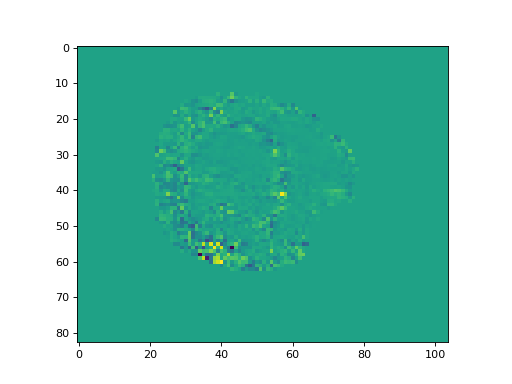

In [10]:
# Enable interactive plot
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()



# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(voxel_data.shape[2]):
    im = plt.imshow(np.flipud(voxel_data[:,:,i]), animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=1)

# ani.save('dynamic_images.mp4')

plt.show()

___
# ###################END###################
____